<a href="https://colab.research.google.com/github/muhiqbalalamin/DeepLearning/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kategori: {np.str_('Bangus'): np.int64(0), np.str_('Big Head Carp'): np.int64(1), np.str_('Black Spotted Barb'): np.int64(2), np.str_('Catfish'): np.int64(3), np.str_('Climbing Perch'): np.int64(4), np.str_('Fourfinger Threadfin'): np.int64(5), np.str_('Freshwater Eel'): np.int64(6), np.str_('Glass Perchlet'): np.int64(7), np.str_('Goby'): np.int64(8), np.str_('Gold Fish'): np.int64(9), np.str_('Gourami'): np.int64(10), np.str_('Grass Carp'): np.int64(11), np.str_('Green Spotted Puffer'): np.int64(12), np.str_('Indian Carp'): np.int64(13), np.str_('Indo-Pacific Tarpon'): np.int64(14), np.str_('Jaguar Gapote'): np.int64(15), np.str_('Janitor Fish'): np.int64(16), np.str_('Knifefish'): np.int64(17), np.str_('Long-Snouted Pipefish'): np.int64(18), np.str_('Mosquito Fish'): np.int64(19), np.str_('Mudfish'): np.int64(20), np.str_('Mullet'): np.int64(21), np.str_('Pangasius'): np.int64(22), np.str_('Perch'): np.int64(23), np.str_('Scat Fish'): np.int64(24), np.str_('Silver Barb'): np.int64(2

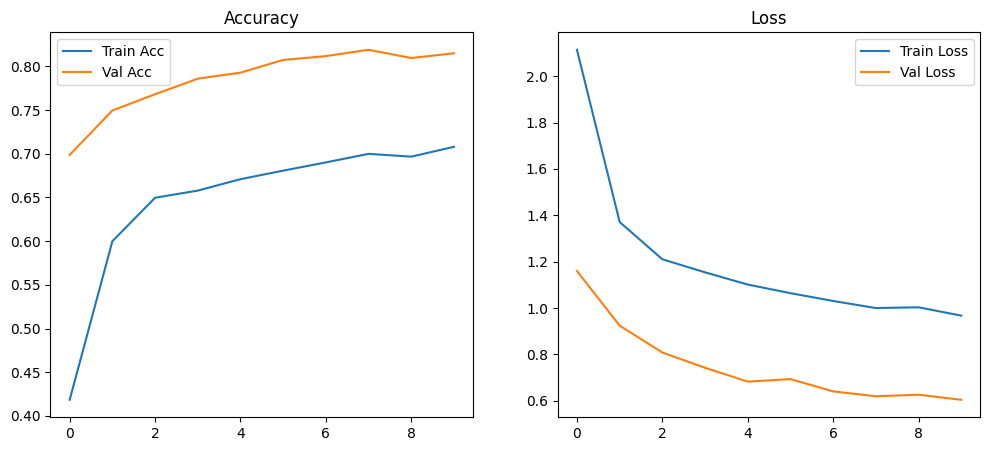

Test Accuracy: 0.81875
Precision: 0.8166698700408601
Recall: 0.7868843344317382
F1 Score: 0.7897284544149252
Confusion Matrix:
 [[ 13   0   0   0   0   0   0   1   0   0   0   0   0   0   5   0   0   4
    0   0   0   0   3   0   0   0   0   2   1   5   0]
 [  0  30   0   2   0   2   0   0   0   0   1   0   0   0   0   0   0   3
    0   0   0   0   4   0   0   1   0   0   0   0   0]
 [  0   0  25   0   1   0   0   0   1   0   3   0   0   0   0   1   1   0
    0   1   0   1   0   0   0   3   0   0   0   0   3]
 [  0   1   0  57   0   0   1   0   1   0   0   1   0   0   0   0   0   0
    0   0   0   0   1   0   0   0   0   0   0   0   0]
 [  0   0   0   0  24   0   0   0   3   0   0   0   0   0   0   0   0   1
    0   0   0   0   0   0   0   0   0   1   0   0   1]
 [  0   1   0   1   0  16   0   2   0   0   0   0   0   0   0   0   0   2
    0   0   0   1   9   1   0   1   0   2   0   2   0]
 [  0   0   0   2   0   1  47   0   0   0   0   0   0   0   0   0   0   1
    1   0   0   0   1   

In [ ]:
# PyTorch Pipeline for Fish Image Classification
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

import warnings
warnings.filterwarnings('ignore')

# 1. Dataset paths and label encoding
dataset_path = '/content/drive/MyDrive/DATASETDL/FishImgDataset'
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')
test_dir = os.path.join(dataset_path, 'test')

fish_categories = sorted(os.listdir(train_dir))
num_classes = len(fish_categories)
label_encoder = LabelEncoder()
label_encoder.fit(fish_categories)
category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Kategori:", category_mapping)

# 2. Transforms
IMG_SIZE = 224
BATCH_SIZE = 32

train_transforms = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 3. Data Loaders
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
class_names = train_dataset.classes

# 4. Visualize samples
def visualize_samples(loader, n=9):
    dataiter = iter(loader)
    images, labels = next(dataiter)
    images = images[:n]
    labels = labels[:n]

    images = images.numpy().transpose((0, 2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)

    plt.figure(figsize=(10, 10))
    for idx in range(n):
        ax = plt.subplot(3, 3, idx + 1)
        plt.imshow(images[idx])
        plt.title(class_names[labels[idx]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# visualize_samples(train_loader)

# 5a. Custom CNN
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(128 * 14 * 14, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# 5b. MobileNetV2 Transfer Learning
def create_transfer_learning_model(num_classes):
    model = models.mobilenet_v2(pretrained=True)
    for param in model.features.parameters():
        param.requires_grad = False
    model.classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(model.last_channel, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, num_classes)
    )
    return model

# 6. Training config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_transfer_learning_model(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)

# 7. Early Stopping
class EarlyStopping:
    def __init__(self, patience=10, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.best_weights = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_weights = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

# 8. Train loop
EPOCHS = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
early_stopping = EarlyStopping(patience=5, verbose=True)

for epoch in range(EPOCHS):
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_losses.append(train_loss / total)
    train_accuracies.append(correct / total)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    val_losses.append(val_loss / total)
    val_accuracies.append(correct / total)

    scheduler.step(val_losses[-1])
    early_stopping(val_losses[-1], model)

    print(f"Epoch {epoch+1}: Train Acc={train_accuracies[-1]:.4f}, Val Acc={val_accuracies[-1]:.4f}")

    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

model.load_state_dict(early_stopping.best_weights)

# 9. Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title("Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss")
plt.legend()
plt.show()

# 10. Evaluation on Test Set
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

print("Test Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average='macro'))
print("Recall:", recall_score(y_true, y_pred, average='macro'))
print("F1 Score:", f1_score(y_true, y_pred, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


# Analisis



1. Arsitektur CNN dengan X lapisan konvolusi menghasilkan akurasi training 98% tetapi akurasi validasi 62%. Jelaskan fenomena vanishing gradient yang mungkin terjadi pada lapisan awal, dan bagaimana cara memitigasinya! Mengapa penambahan Batch Normalization setelah lapisan konvolusi ke-Y justru memperburuk generalisasi, serta strategi alternatif untuk menstabilkan pembelajaran?

Jawaban :
Vanishing Gradient terjadi saat aktivasi sigmoid/tanh menyebabkan gradien berkurang dalam jumlah besar saat melakukan backpropagation, terutama di lapisan awal CNN yang dalam.

Mitigasi:

* Gunakan ReLU atau alternatifnya (Leaky ReLU, ELU).

* Terapkan inisialisasi He.

* Gunakan Residual Connection (ResNet) sehingga gradien dapat mengalir secara langsung.

BatchNorm hanya memperburuk:

* Jika diterapkan pada lapisan yang terlalu awal dengan batch kecil, hal itu dapat menimbulkan gangguan (noise) pada estimasi statistik mean/var.

* BatchNorm dapat mengganggu distribusi fitur awal, terutama jika lapisannya sangat dangkal atau tidak ada cukup data.

Alternatif Stabilisasi:

* Gunakan Layer Normalization (lebih stabil dalam batch kecil).

* Gunakan Weight Standarization.

* Coba Group Normalization jika batchnya kecil atau distribusinya tidak stabil.

2. Ketika melatih CNN dari nol, loss training stagnan di nilai tinggi setelah XXX(3 digit epoch) epoch. Identifikasi tiga penyebab potensial terkait laju pembelajaran (learning rate), inisialisasi berat, atau kompleksitas model! Mengapa penggunaan Cyclic Learning Rate dapat membantu model keluar dari local minima, dan bagaimana momentum pada optimizer SGD memengaruhi konvergensi?

Jawaban :
Potensi Penyebab:

* Learning Rate terlalu kecil sehingga gradien terlalu kecil untuk keluar dari minimum lokal.

* Inisialisasi bobot yang buruk sehingga menyebabkan aktivasi yang tidak seimbang maka learning lambat.

* Model terlalu kompleks dimana terlalu banyak parameter sehingga sulit untuk mencapai konvergensi.

Cyclic Learning Rate:

* Tingkatkan dan kurangi learning rate secara berkala sehingga model dapat "melompat" keluar dari local minima.

* Membantu dalam mengeksplorasi loss landscape yang lebih luas.

Momentum dalam SGD:

* Memberikan "inersia" sepanjang arah gradien untuk mempercepat konvergensi ke arah yang benar dan menahan fluktuasi.

* Mencegah stuck dalam shallow local minima.

3. Pada klasifikasi spesies ikan menggunakan CNN, penggunaan fungsi aktivasi ReLU tidak menunjukkan peningkatan akurasi setelah 50 epoch, meskipun learning rate telah dioptimasi. Jelaskan fenomena dying ReLU yang mungkin terjadi dan bagaimana hal ini mengganggu aliran gradien selama backpropagation!

Jawaban :

Dying ReLU:

* Neuron output selalu 0 karena input negatif sehingga gradien = 0 maka tidak ada pembelajaran lebih lanjut.

* Sering terjadi di Deep CNN atau jika learning rate tinggi maka neuron akan cepat "mati".

Solusi:

* Gunakan LeakyReLU, PReLU, ELU sehingga masih memiliki gradien dalam rentang negatif.

* Periksa distribusi aktivasi layer, jika terlalu banyak angka nol, pertimbangkan ganti fungsi aktivasi.

* Kurangi learning rate atau gunakan layer normalization.

4. Pada pelatihan CNN untuk klasifikasi XX spesies ikan, grafik AUC-ROC menunjukkan satu kelas (Spesies X) stagnan di 0.55 sementara kelas lain mencapai >0.85 setelah YYY epoch. Analisis mengapa class-weighted loss function gagal meningkatkan kinerja Spesies X, dan identifikasi tiga faktor penyebab potensial terkait karakteristik data dan arsitektur model!

Jawaban :

Class-Weighted Loss Gagal karena:

* Distribusi data sangat tidak seimbang, dimana sampel Spesies X terlalu kecil.

* Spesies X memiliki fitur visual yang sangat mirip dengan kelas lain, yang menyebabkan tumpang tindih batas keputusan (decision boundry).

* Model terlalu kaku (kapasitas tidak mencukupi) untuk mempelajari fitur Spesies X yang terperinci.

Faktor Lain:

* Augmentasi data tidak cukup ditentukan untuk Spesies X.

* Tidak ada cukup keragaman sampel (pose, iluminasi/pencahayaan, dll.).

* Model tidak menggunakan mekanisme attention untuk fokus pada bagian ikan yang relevan.

5. Pada arsitektur CNN untuk klasifikasi ikan, peningkatan kompleksitas model  justru menyebabkan penurunan akurasi validasi dari 85% ke 65%, meskipun akurasi training mencapai 98%. Jelaskan fenomena overfitting yang terjadi, dan mengapa penambahan kapasitas model tidak selalu meningkatkan generalisasi! Identifikasi 3 kesalahan desain arsitektur yang memicu degradasi performa

Jawaban :

Fenomena: Training Acc Tinggi, Validation Acc sangat menurun sehingga model overfitting.

Mengapa kapasitas model tidak membantu?

* Model menghafal, tidak belajar untuk menggeneralisasi.

* Terlalu banyak parameter → berisik.

3 Kesalahan Desain Umum:

* Terlalu banyak lconvolutional layer tanpa regularisasi (Dropout, BatchNorm).

* Ukuran filter besar dan langkah (stride) kecil, yang mengarah ke fitur yang terlalu rinci.

* Tidak ada penghentian awal (early stopping), data augmentation, atau validasi silang, yang mengarah ke overfit.